In [1]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
with open('naver_news_summary.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-09-10 20:51:03.865141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 20:51:05.670258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 20:51:08.397496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning

In [4]:
model = SentenceTransformer('snunlp/KR-SBERT-Medium-extended-klueNLItriplet_PARpair_QApair-klueSTS')
model = model.to('cuda')

In [5]:
for key in data.keys():
    print(key, len(data[key]))

economy 340
politics 325
international 352
science 356
social 338
culture 307


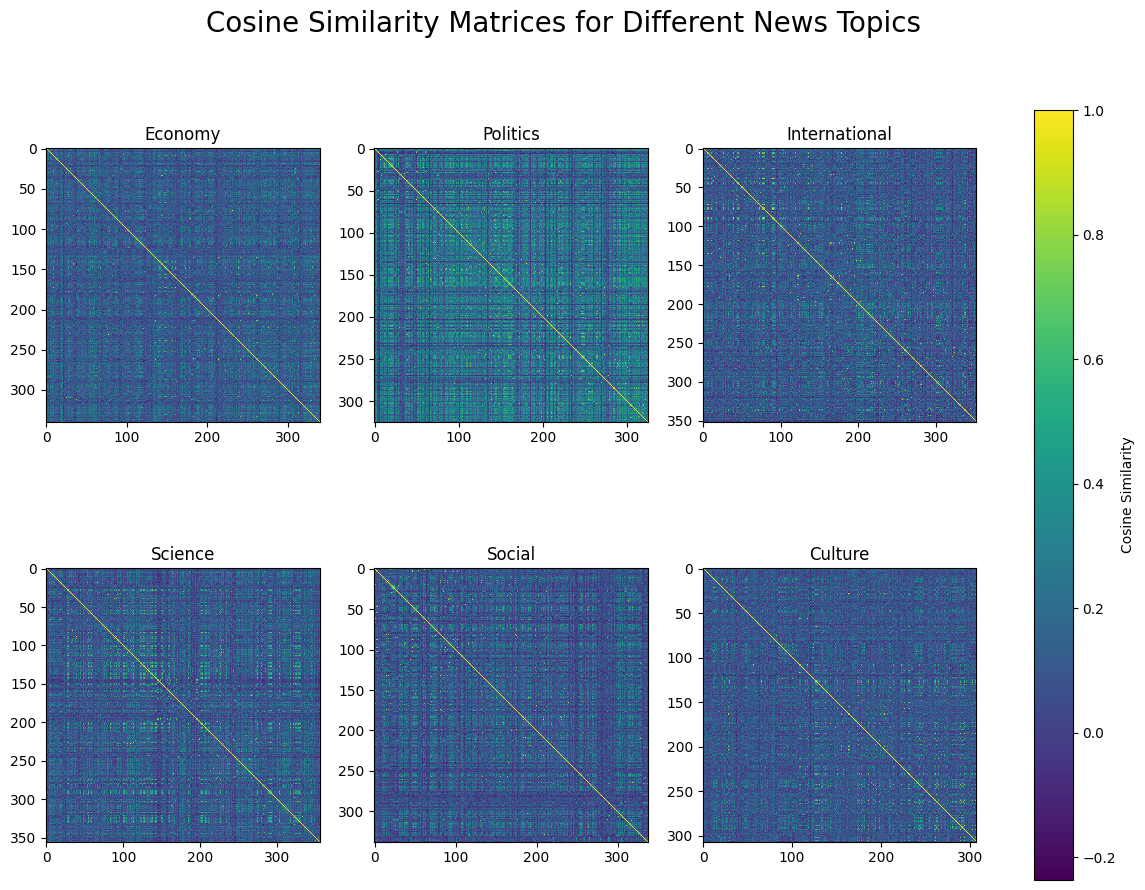

In [13]:
# 먼저 사용할 key의 수를 가져옵니다.
num_keys = len(data.keys())

# 2행 3열로 서브플롯을 설정합니다 (최대 6개의 서브플롯).
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# key 별로 subplot을 그립니다.
for i, key in enumerate(data.keys()):
    sentences    = data[key]
    embeddings   = model.encode(sentences)
    similarities = model.similarity(embeddings, embeddings)
    
    # 축 좌표를 계산하여 subplot에 접근
    ax = axes[i // 3, i % 3]
    cax = ax.imshow(similarities, cmap='viridis', interpolation='nearest')
    # fig.colorbar(cax, ax=ax, label='Similarity')
    ax.set_title(f'{key[0].upper()+key[1:]}')

# 전체 figure에 대한 제목 설정
fig.suptitle('Cosine Similarity Matrices for Different News Topics', fontsize=20, x=0.47)

# 모든 서브플롯에 대해 하나의 colorbar만 생성
fig.colorbar(cax, ax=axes, orientation='vertical', label='Cosine Similarity')

# 레이아웃 조정
# plt.tight_layout()
plt.show()

In [7]:
import seaborn as sns

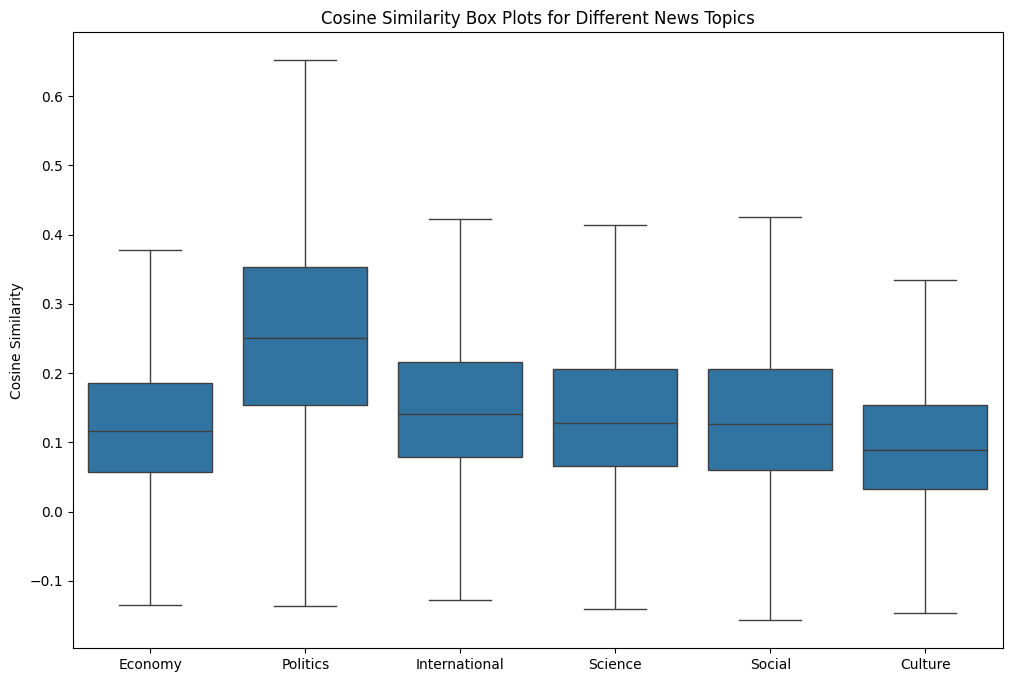

In [14]:
# 상삼각형 값을 저장할 리스트와 라벨을 저장할 리스트
upper_triangle_values_all = []
labels = []

# 각 key에 대해 유사성 계산 및 상삼각형 값 추출
for i, key in enumerate(data.keys()):
    sentences = data[key]
    embeddings = model.encode(sentences)
    similarities = model.similarity(embeddings, embeddings)

    similarities = similarities.detach().cpu().numpy()  # 텐서일 경우 numpy로 변환

    # 상삼각형 부분 추출 (대각선 제외)
    upper_triangle_values = similarities[np.triu_indices(similarities.shape[0], k=1)]

    # # IQR(Interquartile Range)을 이용하여 이상치 제거
    # Q1 = np.percentile(upper_triangle_values, 25)
    # Q3 = np.percentile(upper_triangle_values, 75)
    # IQR = Q3 - Q1

    # # 이상치 기준: Q1 - 1.5 * IQR 보다 작거나 Q3 + 1.5 * IQR 보다 큰 값 제거
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    # filtered_values = upper_triangle_values[(upper_triangle_values >= lower_bound) & (upper_triangle_values <= upper_bound)]

    # 상삼각형 값 저장 (이상치 제거 후)
    upper_triangle_values_all.extend(upper_triangle_values)

    # 각 값에 해당하는 key 이름을 대문자로 변환하여 라벨로 추가
    labels.extend([key[0].upper()+key[1:]] * len(upper_triangle_values))

    
# 수염 그래프 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x=labels, y=upper_triangle_values_all, showfliers=False)
plt.title("Cosine Similarity Box Plots for Different News Topics")
# plt.xticks(rotation=45)  # key 이름이 많을 때 가독성을 위해 회전
plt.ylabel('Cosine Similarity')
plt.show()